In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import secrets
import datetime

In [683]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, charging_probabilities=None):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0

        # Set charging probabilities or attribute values if None
        if charging_probabilities is not None:
            self.charging_probabilities = charging_probabilities
        else:
            self.charging_probabilities = {"Fast": 0.5, "Slow": 0.5}

        # Attribute a charging type according to the probabilities in the charging_probabilities dictionary
        self.charging_type = np.random.choice(list(self.charging_probabilities.keys()), p=list(self.charging_probabilities.values()))


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, charging_stations, initial_soc=None, stopping_soc=None, charging_probabilities=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, charging_probabilities)

        # EV ID
        self.ev_id = secrets.token_hex(16)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc
        # Attribute a random SOC to stop the EV if none is provided
        self.stopping_soc = stopping_soc if stopping_soc is not None else np.random.uniform(0.2, 0.3, 1)[0]

        # List of trips and current trip
        self.trips = []
        self.split_trips = []

        # Information about the charging stations
        self.charging_stations = charging_stations

        # Create a pool of possible charging stations according to EV charging type
        self.default_charging_stations_pool = [charging_station for charging_station in self.charging_stations if
                                               charging_station.charging_station_type == 'Slow']

        self.segment_charging_station_pool = [charging_station for charging_station in self.charging_stations if
                                              charging_station.charging_station_type == 'Fast']

        # Attribute a default charging station from the pool and attribute the EV ID to it
        self.default_charging_station = np.random.choice(self.default_charging_stations_pool, 1)[0]
        self.default_charging_station.ev_id = self.ev_id

        # Attribute a random Fast charging station
        self.segment_charging_station = np.random.choice(self.segment_charging_station_pool, 1)[0]
        self.segment_charging_station.ev_id = self.ev_id

        # Create a list of charging stations
        self.charging_stations_list = [self.default_charging_station, self.segment_charging_station]

        # Number of stops
        self.number_of_stops = 0

        # Charging times
        self.charging_start_time = []
        self.charging_end_time = []
        self.charging_type = []
        self.charging_power = []
        self.charging_start_soc = []
        self.charging_end_soc = []


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"

    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > 1.0:
            self.current_soc = 1.0

        self.soc.append(self.current_soc)


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount / self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0

        self.soc.append(self.current_soc)


    # Create a method to split the assigned trips in which the EV SOC is not enough to cover it
    def split_ev_trips(self):
        list_split_trips = []

        # Create new DrivableTrip object based on assigned trips and append to the list:
        # - Check if trip required energy is more than the EV SOC
        # - If yes, segment the trip and calculate the covered trip length, the remaining trip length and the energy required for each until the EV SOC is enough to cover the remaining trip
        # - If no, append the trip to the list
        for i in range(len(self.trips)):
            trip = self.trips[i]

            charge_at_end = self.check_charge(trip.profile.profile_name)

            # Check need to split trip
            if trip.trip_required_soc > (self.current_soc - self.stopping_soc):
                # Initialize the covered trip length and remaining trip length
                covered_trip_length = 0
                remaining_trip_length = trip.trip_length

                # Current time for trip start
                current_time = trip.trip_start_time

                # Initialize the energy required for the trip
                energy_required = trip.trip_required_soc

                # Loop to segment the trip until the EV SOC is enough to cover the remaining trip
                while energy_required > (self.current_soc - self.stopping_soc):

                    # Calculate used energy
                    used_energy = (self.current_soc - self.stopping_soc)

                    # Calculate the covered trip length of the current segment
                    current_covered_trip_length = (self.battery_size * used_energy)  / ev.energy_per_km

                    # Check for end of trip
                    if current_covered_trip_length >= remaining_trip_length:
                        current_covered_trip_length = remaining_trip_length
                        used_energy = (current_covered_trip_length * ev.energy_per_km) / self.battery_size

                    # Calculate the covered trip length
                    covered_trip_length += current_covered_trip_length
                    remaining_trip_length -= current_covered_trip_length
                    energy_required -= used_energy
                    self.discharge(used_energy)

                    # Calculate duration of covered distance as datetime
                    covered_trip_duration = current_covered_trip_length / trip.trip_speed
                    covered_trip_duration = datetime.timedelta(hours=covered_trip_duration)

                    # Segment end time
                    trip_end_time = current_time + covered_trip_duration

                    # Create a new DrivableTrip object with segment information and append to the list
                    drivable_trip = DrivableTrip(current_covered_trip_length, trip.trip_speed,
                                                 current_time, trip_end_time, covered_trip_duration,
                                                 profile=trip.profile,
                                                 trip_id=trip.trip_id)

                    # Add the EV information to the trip
                    drivable_trip.ev = self
                    drivable_trip.ev_id = self.ev_id
                    drivable_trip.calculate_trip_energy_consumption()
                    drivable_trip.calculate_trip_required_soc()
                    drivable_trip.assign_ev_battery_size()

                    list_split_trips.append(drivable_trip)

                    # Update the number of stops
                    self.number_of_stops += 1

                    # Determine the time to charge the EV
                    charge_time = (self.battery_size * 0.8 - self.current_soc * self.battery_size) / self.segment_charging_station.charging_station_power * self.segment_charging_station.charging_station_efficiency

                    # Calculate the charge time as datetime
                    charge_time = datetime.timedelta(hours=charge_time)

                    # Calculate the end time of the charge
                    charge_end_time = trip_end_time + charge_time

                    # Update the current time
                    current_time = charge_end_time

                    # Check if there is a next trip
                    if i < len(self.trips) - 1:
                        # Check if the next trip starts before the end of the charge
                        if self.trips[i + 1].trip_start_time < charge_end_time:
                            # Calculate the time to charge the EV
                            charge_time = (self.trips[i + 1].trip_start_time - trip_end_time).total_seconds() / 3600
                            charge_time = datetime.timedelta(hours=charge_time)

                            # Calculate the end time of the charge
                            charge_end_time = trip_end_time + charge_time

                    # Save the current SOC
                    current_soc = self.current_soc

                    # Power to charge the EV (SOC)
                    to_charge_soc = 0.8 - self.current_soc

                    # Charge the EV until it reaches 0.8 of the battery size or the end of the charge
                    if current_time < charge_end_time:
                        # Calculate the charge amount
                        to_charge_soc = (charge_end_time - current_time).total_seconds() / 3600 * self.segment_charging_station.charging_station_power / self.segment_charging_station.charging_station_efficiency / self.battery_size

                    self.charge(to_charge_soc)

                    # Update time
                    current_time = charge_end_time

                    # Update the charging station history
                    #self.segment_charging_station.update_history(trip_end_time, charge_end_time)

                    # Update the charging station history
                    self.charging_start_time.append(trip_end_time)
                    self.charging_end_time.append(charge_end_time)
                    self.charging_type.append(self.segment_charging_station.charging_station_type)
                    self.charging_power.append(self.segment_charging_station.charging_station_power)
                    self.charging_start_soc.append(current_soc)
                    self.charging_end_soc.append(self.current_soc)


                # Discharge the remaining energy
                self.discharge(energy_required)

                # Update current time
                current_time += datetime.timedelta(hours=remaining_trip_length / trip.trip_speed)

                # Check if profile allows charging at end
                if charge_at_end or i == len(self.trips) - 1:

                    # Charge the EV at the end of trip to 0.8 of the battery size if needed
                    if self.current_soc < 1.0:
                        # Update the time to charge the EV using the default charging station
                        charge_time = (self.battery_size * 1.0 - self.current_soc * self.battery_size) / self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency
                        charge_time = datetime.timedelta(hours=charge_time)

                        # Save the current SOC
                        current_soc = self.current_soc

                        self.charge(1.0 - current_soc)

                        # Update the charging station history
                        self.charging_start_time.append(current_time)
                        self.charging_end_time.append(current_time + charge_time)
                        self.charging_type.append(self.default_charging_station.charging_station_type)
                        self.charging_power.append(self.default_charging_station.charging_station_power)
                        self.charging_start_soc.append(current_soc)
                        self.charging_end_soc.append(self.current_soc)

            else:
                # Simply add the trip to the list
                list_split_trips.append(trip)

                # Discharge the required SOC
                self.discharge(trip.trip_required_soc)

                # Update the current time
                current_time = trip.trip_end_time

                # Charge if profile allows
                if charge_at_end or i == len(self.trips) - 1:

                    # Charge the EV at the end of trip to 0.8 of the battery size if needed
                    if self.current_soc < 1.0:
                        # Update the time to charge the EV using the default charging station
                        charge_time = (self.battery_size - self.current_soc * self.battery_size) / self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency
                        charge_time = datetime.timedelta(hours=charge_time)

                        # Save the current SOC
                        current_soc = self.current_soc

                        # Save the current SOC to charge
                        to_charge_soc = 1.0 - self.current_soc

                        # Check if there is a next trip
                        if i < len(self.trips) - 1:
                            # Check if the next trip starts before the end of the charge
                            if self.trips[i + 1].trip_start_time < current_time + charge_time:
                                # Calculate the time to charge the EV
                                charge_time = (self.trips[i + 1].trip_start_time - current_time).total_seconds() / 3600

                                # Calculate the charge amount
                                to_charge_soc = charge_time * self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency / self.battery_size

                                # Convert the charge time to datetime
                                charge_time = datetime.timedelta(hours=charge_time)

                        self.charge(to_charge_soc)

                        # Update the charging station history
                        self.charging_start_time.append(trip.trip_end_time)
                        self.charging_end_time.append(trip.trip_end_time + charge_time)
                        self.charging_type.append(self.default_charging_station.charging_station_type)
                        self.charging_power.append(self.default_charging_station.charging_station_power)
                        self.charging_start_soc.append(current_soc)
                        self.charging_end_soc.append(self.current_soc)


        # Update the trips list
        self.split_trips = list_split_trips


    # Check if will charge the EV according to the user profile name
    def check_charge(self, profile_name):
        return profile_name in ['Work', 'Public', 'Other']


In [684]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_duration = trip_duration


class DrivableTrip(Trip):
    # Init method is the same as Trip class
    def __init__(self, trip_length, trip_speed, trip_start_time, trip_end_time, trip_duration, profile=None, trip_id=None):
        super().__init__(trip_length, trip_start_time, trip_end_time, trip_duration)

        # Information about EV
        self.ev = None
        self.ev_id = None

        # Information about the trip
        self.trip_speed = trip_speed
        self.trip_energy_consumption = None
        self.trip_required_soc = None
        self.covered_trip_length = None
        self.ev_battery_size = None
        self.trip_estimate_arrival = trip_end_time
        self.profile = profile

        # Assign a trip ID
        self.trip_id = trip_id if trip_id is not None else secrets.token_hex(16)


    # Formatted print method
    def __repr__(self):
        return f'Trip length: {self.trip_length} km, trip start time: {self.trip_start_time}, ' \
               f'trip end time: {self.trip_end_time}, trip energy consumption: {self.trip_energy_consumption} kWh, ' \
               f'trip required SOC: {self.trip_required_soc} %'

    # Create a method to calculate the trip energy consumption
    def calculate_trip_energy_consumption(self):
        self.trip_energy_consumption = self.trip_length * self.ev.energy_per_km


    # Create a method to calculate the trip required SOC
    def calculate_trip_required_soc(self):
        self.trip_required_soc = self.trip_energy_consumption / self.ev.battery_size


    # Create a method to assign the battery size of the EV to the trip
    def assign_ev_battery_size(self):
        self.ev_battery_size = self.ev.battery_size


    # Create a method to update the covered trip length
    def update_covered_trip_length(self, covered_trip_length):
        self.covered_trip_length += covered_trip_length


    # Create a method to update the required SOC
    def update_trip_required_soc(self):
        self.trip_required_soc = (self.trip_energy_consumption - self.covered_trip_length * self.ev.energy_per_km) / self.ev.battery_size


In [685]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_cost, charging_station_probability, ev_id=None):
        # Parameters Assign
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_cost = charging_station_cost
        self.charging_station_efficiency = charging_station_efficiency
        self.charging_station_probability = charging_station_probability

        # Charging station history
        self.charging_station_history = []

        # EV ID
        self.ev_id = ev_id


    # Formatted print method
    def __repr__(self):
        return f'Charging station type: {self.charging_station_type}, charging station power: {self.charging_station_power}'


    # Method to update the charging station history to store the logs
    def update_history(self, start_time, end_time):
        self.charging_station_history.append([start_time, end_time])


In [686]:
# Define a User class, that will have the following parameters:
# - User name
# - User location
# - User trips
# - User EV
# - User type

class User:
    def __init__(self, user_name, user_profile):
        # Parameters Assign
        self.user_name = user_name
        self.user_profile = user_profile

    # Method to assign an EV to the user
    def assign_ev(self, ev):
        self.user_ev = ev


# Create a Profile class that will determine the behaviour of the Users. Has the following parameters:
# - Profile name
# - Profile type
# - Profile trip schedule
# - Trip type
class Profile:
    def __init__(self, profile_name, trip_type, profile_trip_schedule):
        # Parameters Assign
        self.profile_name = profile_name
        self.trip_type = trip_type
        self.profile_trip_schedule = profile_trip_schedule

    # Format printing
    def __repr__(self):
        return f'N:{self.profile_name}, T:{self.trip_type}'


# Create a Schedule class with the following parameters:
# - Schedule start
# - Schedule end
class Schedule:
    def __init__(self, schedule_start):
        # Parameters Assign
        self.schedule_start = schedule_start

    # Format printing
    def __repr__(self):
        return f'Schedule start hours: {self.schedule_start}'

In [687]:
 # Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Number of EVs
class Aggregator:
    def __init__(self, profiles, evs, charging_stations):
        # Profile assign
        self.profiles = profiles

        # Assign the EVs to the aggregator
        self.evs = evs

        # Number of EVs of the simulation
        self.number_of_evs = None

        # Create a list of trips
        self.trips = []
        self.segments = []
        self.population = None
        self.assigned_evs = []

        # Assign the charging stations to the aggregator
        self.charging_stations = charging_stations

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)

    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)

    # Assign a charging station to an EV, and charge the EV if:
    # - The charging station is available
    # - The charging station is of the correct type
    # - The charging station has enough power to charge the EV
    def assign_charging_station(self, ev, charging_station):
        if charging_station.charging_station_availability == True and charging_station.charging_station_type == ev.battery_type and charging_station.charging_station_power >= ev.battery_size:
            ev.current_charging_station = charging_station
            ev.charge(charging_station.charging_station_power)
            charging_station.charging_station_availability = False


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_evs(self, n_evs):
        # Assign the number of EVs to the aggregator
        self.number_of_evs = n_evs

        # Create an EV population according to the given probabilities of the EVs
        population_choice = np.random.choice(self.evs, n_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = [DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      self.charging_stations,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                           for ev in population_choice]


    # Create DrivableTrips with gamma distribution for the trip length
    # Create a gamma distribution for the trip length
    def create_trips(self, n_trips, time_resolution=1, avg_speed_short=60, avg_speed_medium=80, avg_speed_long=100, medium_trip_min=50, medium_trip_max=100, trip_start_variation=1.0, avg_speed_variation=1.0):
        shape, scale = 46.*.01, 46.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, n_trips), 2)

        # Assign the trip lengths to the trips list
        self.trips = [Trip(trip_length, None, None, None) for trip_length in trip_lengths]

        # Create the DrivableTrips
        for trip in range(n_trips):

            # Calculate trip type based on distance
            trip_type = 'Short' if trip_lengths[trip] <= medium_trip_min else 'Medium' if medium_trip_min < trip_lengths[trip] <= medium_trip_max else 'Long'

            # Calculate average speed based on trip type
            avg_speed = avg_speed_short if trip_type == 'Short' else avg_speed_medium if trip_type == 'Medium' else avg_speed_long

            # Get the user profiles that match the trip type
            user_profiles = [profile for profile in self.profiles if profile.trip_type == trip_type]

            # Get the user profile based on the user profiles that match the trip type
            user_profile = np.random.choice(user_profiles, 1)[0]

            # Check how many trips the user has
            user_trips = len(user_profile.profile_trip_schedule.schedule_start)

            # If there are more than 1 trip, split into multiple trips
            if user_trips > 1:

                # Placeholder for list of segments of each trip. Each segment is a DrivableTrip
                segment_list = []

                # Calculate the required socs for trip segment
                for i in range(user_trips):
                    # Get a random start centered around schedule start
                    segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[i] - trip_start_variation,
                                                      user_profile.profile_trip_schedule.schedule_start[i] + trip_start_variation, 1)[0]

                    # Get a random average speed centered on avg_speed with variation
                    segment_avg_speed = np.random.uniform(avg_speed - avg_speed_variation, avg_speed + avg_speed_variation, 1)[0] * time_resolution

                    # Calculate the segment end
                    segment_end = segment_start + trip_lengths[trip] / segment_avg_speed

                    # Calculate the segment length
                    duration = segment_end - segment_start if segment_end > segment_start else 0

                    # Convert float values to timestamp
                    segment_start = datetime.datetime(2023, 1, 1, int(segment_start), int((segment_start - int(segment_start)) * 60))
                    segment_end = datetime.datetime(2023, 1, 1, int(segment_end), int((segment_end - int(segment_end)) * 60))
                    #duration = datetime.datetime(2023, 1, 1, int(duration), int((duration - int(duration)) * 60))
                    duration = datetime.timedelta(hours=duration)

                    # Create a DrivableTrip for each segment
                    segment_list.append(DrivableTrip(trip_lengths[trip] / user_trips,
                                                     segment_avg_speed,
                                                     segment_start, segment_end,
                                                     duration, profile=user_profile))

                # Append to the trips list
                self.segments.append(segment_list)

            elif user_trips == 1:

                # Get a random start centered around schedule start
                segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[0] - trip_start_variation,
                                                  user_profile.profile_trip_schedule.schedule_start[0] + trip_start_variation, 1)[0]

                # Get a random average speed centered on avg_speed with variation
                segment_avg_speed = np.random.uniform(avg_speed - avg_speed_variation, avg_speed + avg_speed_variation, 1)[0] * time_resolution

                # Calculate the segment end
                segment_end = segment_start + trip_lengths[trip] / segment_avg_speed

                # Calculate the segment length
                duration = segment_end - segment_start if segment_end > segment_start else 0

                # Convert float values to time
                segment_start = datetime.datetime(2023, 1, 1, int(segment_start), int((segment_start - int(segment_start)) * 60))
                segment_end = datetime.datetime(2023, 1, 1, int(segment_end), int((segment_end - int(segment_end)) * 60))
                #duration = datetime.datetime(2023, 1, 1, int(duration), int((duration - int(duration)) * 60))
                duration = datetime.timedelta(hours=duration)

                # Create a DrivableTrip for the trip
                drivable_trip = DrivableTrip(trip_lengths[trip],
                                             segment_avg_speed,
                                             segment_start, segment_end,
                                             duration, profile=user_profile)

                # Append to the segments list
                self.segments.append([drivable_trip])


    # Assign the larger trips to the EVs with larger battery sizes with a greater probability
    def assign_trips(self):
        # Create a copy of the population
        population_copy = copy.deepcopy(self.population)
        segments_copy = copy.deepcopy(self.segments)

        # Assigned EVs and Trips
        assigned_evs = []

        # Create a list with the probabilities of the EVs to get a trip
        probabilities = [ev.battery_size / sum([ev.battery_size for ev in self.population]) for ev in population_copy]

        # Sort the segments by trip length and assign it to a temporary variable
        sorted_segments = sorted(segments_copy, key=lambda x: x[0].trip_length, reverse=True)

        # Assign the sorted trips to the EVs
        for segment in sorted_segments:
            # Choose an EV from the population
            ev = np.random.choice(population_copy, 1, p=probabilities)[0]

            for trip in segment:
                # Assign the trip segments to the EV
                trip.ev = ev
                trip.ev_id = ev.ev_id
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()
                trip.assign_ev_battery_size()

                # Add the trip to the EV
                ev.add_trip(trip)

                # Calculate the trip energy consumption and required SOC
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()

            # Split the trip into segments
            ev.split_ev_trips()

            # Remove the EV from the population
            population_copy.remove(ev)

            self.assigned_evs.append(ev)

            # Recalculate the probabilities
            probabilities = [ev.battery_size / sum([ev.battery_size for ev in population_copy]) for ev in population_copy]

            # If the population is empty, break the loop
            if len(population_copy) == 0:
                break


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe


    # Create a DataFrame of assigned EVs
    def assigned_evs_dataframe(self):
        # Create a DataFrame of the population
        assigned_evs_dataframe = pd.DataFrame([ev.__dict__ for ev in self.assigned_evs])

        # Return the DataFrame
        return assigned_evs_dataframe


    # Create a DataFrame of the trips
    def assigned_trips_dataframe(self):
        # Create a DataFrame of the trips
        trips_dataframe = pd.DataFrame([trip.trip_length for trip in self.trips])
        trips_dataframe.columns = ["trip_length"]

        # Return the DataFrame
        return trips_dataframe


    # Create a DataFrame of assigned Trips and all the information in the list
    def assigned_segments_dataframe(self):
        # Create a DataFrame of the population
        assigned_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.trips])

        # Return the DataFrame
        return assigned_trips_dataframe

    # Create a DataFrame of the EVs' split trips
    def assigned_split_trips_dataframe(self):
        # Create a DataFrame of the population
        assigned_split_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.split_trips])

        # Return the DataFrame
        return assigned_split_trips_dataframe


    # Create a DataFrame of the charging stations used by the EVs
    def assigned_cs_dataframe(self):
        # Create a DataFrame of the population
        assigned_cs_dataframe = pd.DataFrame([cs.__dict__ for ev in self.assigned_evs for cs in ev.charging_stations_list])

        # Return the DataFrame
        return assigned_cs_dataframe


    # Create a DataFrame with history information of the CS
    def assigned_cs_history_dataframe(self):

        # Create a list for start and end times, EV ID
        start_times = []
        end_times = []
        ev_ids = []

        # Iterate through the EVs
        for ev in self.assigned_evs:
            # Iterate through the charging stations
            for cs in ev.charging_stations_list:
                # Iterate through the charging sessions
                for i in range(len(cs.charging_station_history)):
                    # Append the start and end times
                    start_times.append(cs.charging_station_history[i][0])
                    end_times.append(cs.charging_station_history[i][1])
                    ev_ids.append(ev.ev_id)

        # Create a DataFrame
        cs_history_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "ev_id": ev_ids})

        # Return the DataFrame
        return cs_history_dataframe


    # Create a DataFrame composed by:
    # EV charging start time, EV charging end time, EV charging start soc, EV charging end soc, EV ID
    def cs_charging_dataframe(self):

        # Create placeholder lists
        start_times = []
        end_times = []

        station_type = []
        station_power = []

        start_socs = []
        end_socs = []

        ev_ids = []

        # Iterate through the EVs
        for ev in self.assigned_evs:

            # Check if there were any events
            if len(ev.charging_start_time) == 0:
                continue

            # Iterate through the events
            for i in range(len(ev.charging_start_time)):
                start_times.append(ev.charging_start_time[i])
                end_times.append(ev.charging_end_time[i])

                station_type.append(ev.charging_type[i])
                station_power.append(ev.charging_power[i])

                start_socs.append(ev.charging_start_soc[i])
                end_socs.append(ev.charging_end_soc[i])

                ev_ids.append(ev.ev_id)

        # Create the DataFrame
        charging_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "start_soc": start_socs,
                                           "end_soc": end_socs, "ev_id": ev_ids, "station_type": station_type, "station_power": station_power})

        # Return the DataFrame
        return charging_dataframe

In [688]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissan', model='Leaf', battery_type='BEV', battery_size=59,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.17, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=95,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.18, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Peugeot', model='e-Expert', battery_type='BEV', battery_size=68,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.26, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=52,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.17, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=85,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.22, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=13.5,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.18, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=70.2,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.16, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Audi Q4', model='e-tron', battery_type='PHEV', battery_size=55,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.17, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=74,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.192, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Volvo', model='XC40', battery_type='PHEV', battery_size=78,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.176, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Wolkswagen', model='ID.3', battery_type='PHEV', battery_size=58,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.155, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5})]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [689]:
# Create a list of Charging Stations to use in the simulation

CS = [ChargingStation(charging_station_type='Slow',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Slow',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25)]

In [690]:
# Create the profiles to use in the simulation

# Create a list of profiles
PROFILES = [Profile(profile_name='Residential', profile_trip_schedule=Schedule([8, 16]), trip_type='Short'),
            Profile(profile_name='Residential', profile_trip_schedule=Schedule([5, 18]), trip_type='Medium'),
            Profile(profile_name='Shopping', profile_trip_schedule=Schedule([8, 18]), trip_type='Short'),
            Profile(profile_name='Work', profile_trip_schedule=Schedule([8]), trip_type='Long')]

In [691]:
# Create an Aggregator object
aggregator = Aggregator(profiles=PROFILES, evs=EVs, charging_stations=CS)

# Create the population of EVs
aggregator.create_evs(n_evs=100)

# Create the trips
aggregator.create_trips(n_trips=100,
                        avg_speed_short=60,
                        avg_speed_medium=80,
                        avg_speed_long=100)

# Assign the EVs to the trips and calculate the trip energy consumption and required SOC.
# Also, assign the trip to the EV
aggregator.assign_trips()

Required SOC:  0.7854
Current SOC:  0.21908485260047306
Used energy:  0.44182363265957425
Charge time:  7.551896916193851


Required SOC:  0.6185333333333333
Current SOC:  0.18679245571457326
Used energy:  0.5518867898568841
Charge time:  1.0347877309816578


Required SOC:  0.6185333333333333
Current SOC:  0.20183384120372605
Used energy:  0.4165143204545091
Charge time:  1.0094053929687123


Required SOC:  0.27390000000000003
Current SOC:  0.25312484882021224
Used energy:  0.23628763606180891
Charge time:  2.734375755898939


Required SOC:  0.35473333333333334
Current SOC:  0.18480154318485598
Used energy:  0.1719452778002963
Charge time:  1.0381473958755556




In [692]:
# Print the population
aggregator.population_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,segment_charging_station_pool,default_charging_station,segment_charging_station,charging_stations_list,number_of_stops,charging_start_time,charging_end_time,charging_power,charging_start_soc,charging_end_soc
0,Volvo,XC40,PHEV,78.0,0.9,0.9,0.176,0.7,1.0,0.05,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
1,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
2,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
3,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
4,Volvo,XC40,PHEV,78.0,0.9,0.9,0.176,0.7,1.0,0.05,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.170,0.7,1.0,0.07,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
96,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.7,1.0,0.16,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
97,Hyundai,Kauai,BEV,74.0,0.9,0.9,0.192,0.7,1.0,0.06,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]
98,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[],[],[],[],[]


In [693]:
# Print the assigned EVs

aggregator.assigned_evs_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,segment_charging_station_pool,default_charging_station,segment_charging_station,charging_stations_list,number_of_stops,charging_start_time,charging_end_time,charging_power,charging_start_soc,charging_end_soc
0,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",1,"[2023-01-01 09:19:55.315468, 2023-01-01 18:08:...","[2023-01-01 16:53:02.144366, 2023-01-01 22:17:...","[3.6, 7.2]","[0.21908485260047306, 0.3601569659929077]","[0.7419084852600474, 0.9360156965992907]"
1,Jaguar,I-Pace,BEV,85.0,0.9,0.9,0.220,0.7,1.0,0.09,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 11:00:00],[2023-01-01 19:01:13.600000],[7.2],[0.24513464052287592],[0.9245134640522876]
2,Jaguar,I-Pace,BEV,85.0,0.9,0.9,0.220,0.7,1.0,0.09,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 09:29:00],[2023-01-02 01:34:16.400000],[3.6],[0.24292287581699346],[0.9242922875816993]
3,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.170,0.7,1.0,0.07,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 10:00:00],[2023-01-01 19:14:47.800000],[3.6],[0.3275191919191919],[0.9327519191919192]
4,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.7,1.0,0.16,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 08:57:00],[2023-01-01 13:21:41.100000],[7.2],[0.4018418079096044],[0.9401841807909603]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Others,Others,PEV,20.0,0.9,0.9,0.200,0.7,1.0,0.03,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 16:17:00],[2023-01-01 17:02:12],[3.6],[0.8493333333333334],[0.9849333333333333]
96,Volvo,XC40,PHEV,78.0,0.9,0.9,0.176,0.7,1.0,0.05,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 18:28:00],[2023-01-01 19:03:10.400000],[7.2],[0.9398746438746439],[0.9939874643874644]
97,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 17:59:00],[2023-01-01 18:16:13.650000],[7.2],[0.8298518518518517],[0.9829851851851852]
98,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,"[Charging station type: Fast, charging station...","Charging station type: Slow, charging station ...","Charging station type: Fast, charging station ...","[Charging station type: Slow, charging station...",0,[2023-01-01 18:15:00],[2023-01-01 19:52:30],[7.2],[0.75],[0.975]


In [694]:
# Print the trips

aggregator.assigned_trips_dataframe()

,trip_length
0,0.00
1,3.32
2,67.98
3,54.78
4,12.11
...,...
95,7.60
96,38.54
97,0.78
98,127.08


In [695]:
# Print trip segments

aggregator.assigned_segments_dataframe()

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_speed,trip_energy_consumption,trip_required_soc,covered_trip_length,ev_battery_size,trip_estimate_arrival,profile,trip_id
0,240.240,2023-01-01 08:11:00,2023-01-01 10:36:00,0 days 02:24:08.318491,Renault Zoe with 52 kWh battery,6ef6d268ca4df0f29fb38e8cc8a0c5e5,100.003718,40.8408,0.785400,None,52.0,2023-01-01 10:36:00,"N:Work, T:Long",1a3389e57720bc90f66d77baf6b71cd3
1,220.760,2023-01-01 08:48:00,2023-01-01 11:00:00,0 days 02:12:18.367968,Jaguar I-Pace with 85 kWh battery,3d9dca3defb54dfc3e27263077b5f57d,100.113273,48.5672,0.571379,None,85.0,2023-01-01 11:00:00,"N:Work, T:Long",b5dde811548382f2196e69b8ad07a8ef
2,207.620,2023-01-01 07:23:00,2023-01-01 09:29:00,0 days 02:05:37.017847,Jaguar I-Pace with 85 kWh battery,da3a6b214f661a186e0887b52b99f2af,99.168135,45.6764,0.537369,None,85.0,2023-01-01 09:29:00,"N:Work, T:Long",6030085bf3cf18c57514ecc00998e50a
3,178.340,2023-01-01 08:13:00,2023-01-01 10:00:00,0 days 01:47:14.048981,Audi Q4 e-tron with 55 kWh battery,2229e7c09b6f534bc7b5e6d227aa343b,99.785376,30.3178,0.551233,None,55.0,2023-01-01 10:00:00,"N:Work, T:Long",d4cd150631cabc4d156ed2db5c193af7
4,136.860,2023-01-01 07:36:00,2023-01-01 08:57:00,0 days 01:21:47.309899,Nissan Leaf with 59 kWh battery,1767f919a2c91b09c96d49adb56c02a2,100.400425,23.2662,0.394342,None,59.0,2023-01-01 08:57:00,"N:Work, T:Long",f7cc8a2e93e4ff11af06d68e64a9a70e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.005,2023-01-01 17:59:00,2023-01-01 17:59:00,0 days 00:00:00.607490,Mercedes E300 with 13.5 kWh battery,42f1964ff88b5f09f7a45f9ac8be232a,59.260214,0.0009,0.000067,None,13.5,2023-01-01 17:59:00,"N:Shopping, T:Short",469fe828d04ba07e19d8081da2972d70
184,0.000,2023-01-01 08:43:00,2023-01-01 08:43:00,0 days 00:00:00,Renault Zoe with 52 kWh battery,88a6366302a69db06d59dfd0ed2ee42f,60.496789,0.0000,0.000000,None,52.0,2023-01-01 08:43:00,"N:Shopping, T:Short",2da08842f9a10731d510f13df1623c2f
185,0.000,2023-01-01 18:15:00,2023-01-01 18:15:00,0 days 00:00:00,Renault Zoe with 52 kWh battery,88a6366302a69db06d59dfd0ed2ee42f,59.951953,0.0000,0.000000,None,52.0,2023-01-01 18:15:00,"N:Shopping, T:Short",715b96daed43304ca1fe6387dcd0b5e5
186,0.000,2023-01-01 07:55:00,2023-01-01 07:55:00,0 days 00:00:00,Mercedes E300 with 13.5 kWh battery,a07468817181d73d760882a4a97c3964,60.885032,0.0000,0.000000,None,13.5,2023-01-01 07:55:00,"N:Shopping, T:Short",5225b68eaecfaf12aff51437069ef542


In [696]:
# Check trip stops of EVs

aggregator.assigned_split_trips_dataframe()

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_speed,trip_energy_consumption,trip_required_soc,covered_trip_length,ev_battery_size,trip_estimate_arrival,profile,trip_id
0,114.874144,2023-01-01 08:11:00,2023-01-01 09:19:55.315468,0 days 01:08:55.315468,Renault Zoe with 52 kWh battery,6ef6d268ca4df0f29fb38e8cc8a0c5e5,100.003718,19.528605,0.375550,None,52.0,2023-01-01 09:19:55.315468,"N:Work, T:Long",1a3389e57720bc90f66d77baf6b71cd3
1,220.760000,2023-01-01 08:48:00,2023-01-01 11:00:00.000000,0 days 02:12:18.367968,Jaguar I-Pace with 85 kWh battery,3d9dca3defb54dfc3e27263077b5f57d,100.113273,48.567200,0.571379,None,85.0,2023-01-01 11:00:00.000000,"N:Work, T:Long",b5dde811548382f2196e69b8ad07a8ef
2,207.620000,2023-01-01 07:23:00,2023-01-01 09:29:00.000000,0 days 02:05:37.017847,Jaguar I-Pace with 85 kWh battery,da3a6b214f661a186e0887b52b99f2af,99.168135,45.676400,0.537369,None,85.0,2023-01-01 09:29:00.000000,"N:Work, T:Long",6030085bf3cf18c57514ecc00998e50a
3,178.340000,2023-01-01 08:13:00,2023-01-01 10:00:00.000000,0 days 01:47:14.048981,Audi Q4 e-tron with 55 kWh battery,2229e7c09b6f534bc7b5e6d227aa343b,99.785376,30.317800,0.551233,None,55.0,2023-01-01 10:00:00.000000,"N:Work, T:Long",d4cd150631cabc4d156ed2db5c193af7
4,136.860000,2023-01-01 07:36:00,2023-01-01 08:57:00.000000,0 days 01:21:47.309899,Nissan Leaf with 59 kWh battery,1767f919a2c91b09c96d49adb56c02a2,100.400425,23.266200,0.394342,None,59.0,2023-01-01 08:57:00.000000,"N:Work, T:Long",f7cc8a2e93e4ff11af06d68e64a9a70e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.005000,2023-01-01 17:59:00,2023-01-01 17:59:00.000000,0 days 00:00:00.607490,Mercedes E300 with 13.5 kWh battery,42f1964ff88b5f09f7a45f9ac8be232a,59.260214,0.000900,0.000067,None,13.5,2023-01-01 17:59:00.000000,"N:Shopping, T:Short",469fe828d04ba07e19d8081da2972d70
184,0.000000,2023-01-01 08:43:00,2023-01-01 08:43:00.000000,0 days 00:00:00,Renault Zoe with 52 kWh battery,88a6366302a69db06d59dfd0ed2ee42f,60.496789,0.000000,0.000000,None,52.0,2023-01-01 08:43:00.000000,"N:Shopping, T:Short",2da08842f9a10731d510f13df1623c2f
185,0.000000,2023-01-01 18:15:00,2023-01-01 18:15:00.000000,0 days 00:00:00,Renault Zoe with 52 kWh battery,88a6366302a69db06d59dfd0ed2ee42f,59.951953,0.000000,0.000000,None,52.0,2023-01-01 18:15:00.000000,"N:Shopping, T:Short",715b96daed43304ca1fe6387dcd0b5e5
186,0.000000,2023-01-01 07:55:00,2023-01-01 07:55:00.000000,0 days 00:00:00,Mercedes E300 with 13.5 kWh battery,a07468817181d73d760882a4a97c3964,60.885032,0.000000,0.000000,None,13.5,2023-01-01 07:55:00.000000,"N:Shopping, T:Short",5225b68eaecfaf12aff51437069ef542


In [697]:
# Dataframe of the used Charging Stations

aggregator.assigned_cs_dataframe()

,charging_station_type,charging_station_power,charging_station_cost,charging_station_efficiency,charging_station_probability,charging_station_history,ev_id
0,Slow,7.2,0.15,0.9,0.25,[],d9528b072296810f3e8ddb9f0e9508ee
1,Fast,3.6,0.15,0.9,0.25,[],d9528b072296810f3e8ddb9f0e9508ee
2,Slow,7.2,0.15,0.9,0.25,[],d9528b072296810f3e8ddb9f0e9508ee
3,Fast,7.2,0.15,0.9,0.25,[],283de30d3e8982eb2d927e1f0903c66e
4,Slow,3.6,0.15,0.9,0.25,[],283de30d3e8982eb2d927e1f0903c66e
...,...,...,...,...,...,...,...
195,Fast,7.2,0.15,0.9,0.25,[],283de30d3e8982eb2d927e1f0903c66e
196,Slow,7.2,0.15,0.9,0.25,[],d9528b072296810f3e8ddb9f0e9508ee
197,Fast,7.2,0.15,0.9,0.25,[],283de30d3e8982eb2d927e1f0903c66e
198,Slow,7.2,0.15,0.9,0.25,[],d9528b072296810f3e8ddb9f0e9508ee


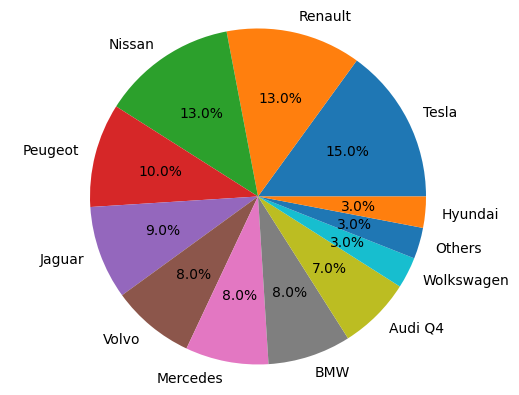

In [698]:
# Plot the population brand in a pie chart

# Values of each group
brand_values = aggregator.population_dataframe()['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()

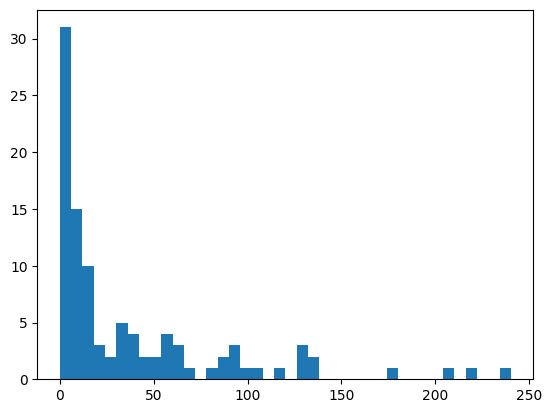

In [699]:
# Plot the trip distances in a histogram
plt.hist(aggregator.assigned_trips_dataframe()['trip_length'], bins=40)
plt.show()

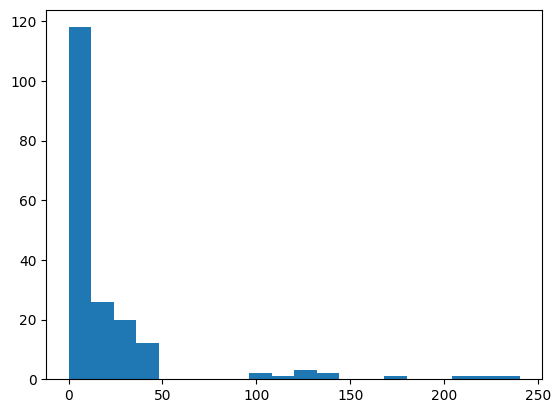

In [700]:
# Plot the segment distances in a histogram
plt.hist(aggregator.assigned_segments_dataframe()['trip_length'], bins=20)
plt.show()

In [701]:
aggregator.assigned_trips_dataframe()['trip_length'].mean()

38.143699999999995

In [702]:
# Get a DataFrame of EV charging history

ev_charging_history = aggregator.cs_charging_dataframe()

# Remove rows with start_time equals to end_time
ev_charging_history = ev_charging_history[ev_charging_history['start_time'] != ev_charging_history['end_time']]

# Remove duplicates
ev_charging_history = ev_charging_history.drop_duplicates()

# Add column with the duration of the charging session
ev_charging_history['duration'] = ev_charging_history['end_time'] - ev_charging_history['start_time']

# Add column with start hour
ev_charging_history['start_hour'] = ev_charging_history['start_time'].dt.hour

# Add column with end hour
ev_charging_history['end_hour'] = ev_charging_history['end_time'].dt.hour

# Show the dataframe
ev_charging_history

,start_time,end_time,start_soc,end_soc,ev_id,station_type,station_power,duration,start_hour,end_hour
0,2023-01-01 09:19:55.315468,2023-01-01 16:53:02.144366,0.219085,0.741908,6ef6d268ca4df0f29fb38e8cc8a0c5e5,Fast,3.6,0 days 07:33:06.828898,9,16
1,2023-01-01 18:08:15.147389,2023-01-01 22:17:47.474385,0.360157,0.936016,6ef6d268ca4df0f29fb38e8cc8a0c5e5,Slow,7.2,0 days 04:09:32.326996,18,22
2,2023-01-01 11:00:00.000000,2023-01-01 19:01:13.600000,0.245135,0.924513,3d9dca3defb54dfc3e27263077b5f57d,Slow,7.2,0 days 08:01:13.600000,11,19
3,2023-01-01 09:29:00.000000,2023-01-02 01:34:16.400000,0.242923,0.924292,da3a6b214f661a186e0887b52b99f2af,Slow,3.6,0 days 16:05:16.400000,9,1
4,2023-01-01 10:00:00.000000,2023-01-01 19:14:47.800000,0.327519,0.932752,2229e7c09b6f534bc7b5e6d227aa343b,Slow,3.6,0 days 09:14:47.800000,10,19
...,...,...,...,...,...,...,...,...,...,...
100,2023-01-01 16:17:00.000000,2023-01-01 17:02:12.000000,0.849333,0.984933,90390634554d4143ba06a800ee2d8920,Slow,3.6,0 days 00:45:12,16,17
101,2023-01-01 18:28:00.000000,2023-01-01 19:03:10.400000,0.939875,0.993987,83845504ac554fc9c0bc7be9cb2b73e9,Slow,7.2,0 days 00:35:10.400000,18,19
102,2023-01-01 17:59:00.000000,2023-01-01 18:16:13.650000,0.829852,0.982985,42f1964ff88b5f09f7a45f9ac8be232a,Slow,7.2,0 days 00:17:13.650000,17,18
103,2023-01-01 18:15:00.000000,2023-01-01 19:52:30.000000,0.750000,0.975000,88a6366302a69db06d59dfd0ed2ee42f,Slow,7.2,0 days 01:37:30,18,19


In [703]:
# Create a DataFrame with the EV IDs as index and hour range as columns to indicate the charging sessions

# Create a DataFrame with the EV IDs as index
ev_charging_history_hourly = pd.DataFrame(index=ev_charging_history['ev_id'].unique())

# Create a list of hours
hours = list(range(0, 24))

# Create a column for each hour
for hour in hours:
    ev_charging_history_hourly['{:02d}'.format(hour)] = 0


# Fill the DataFrame with the charging sessions
for index, row in ev_charging_history.iterrows():
    for hour in range(row['start_hour'], row['end_hour'] + 1):
        ev_charging_history_hourly.loc[row['ev_id'], '{:02d}'.format(hour)] += 1

# Show the DataFrame
ev_charging_history_hourly


,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
6ef6d268ca4df0f29fb38e8cc8a0c5e5,0,0,0,0,0,0,0,0,0,1,...,1,1,1,0,1,1,1,1,1,0
3d9dca3defb54dfc3e27263077b5f57d,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
da3a6b214f661a186e0887b52b99f2af,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2229e7c09b6f534bc7b5e6d227aa343b,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
1767f919a2c91b09c96d49adb56c02a2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90390634554d4143ba06a800ee2d8920,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
83845504ac554fc9c0bc7be9cb2b73e9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
42f1964ff88b5f09f7a45f9ac8be232a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
88a6366302a69db06d59dfd0ed2ee42f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


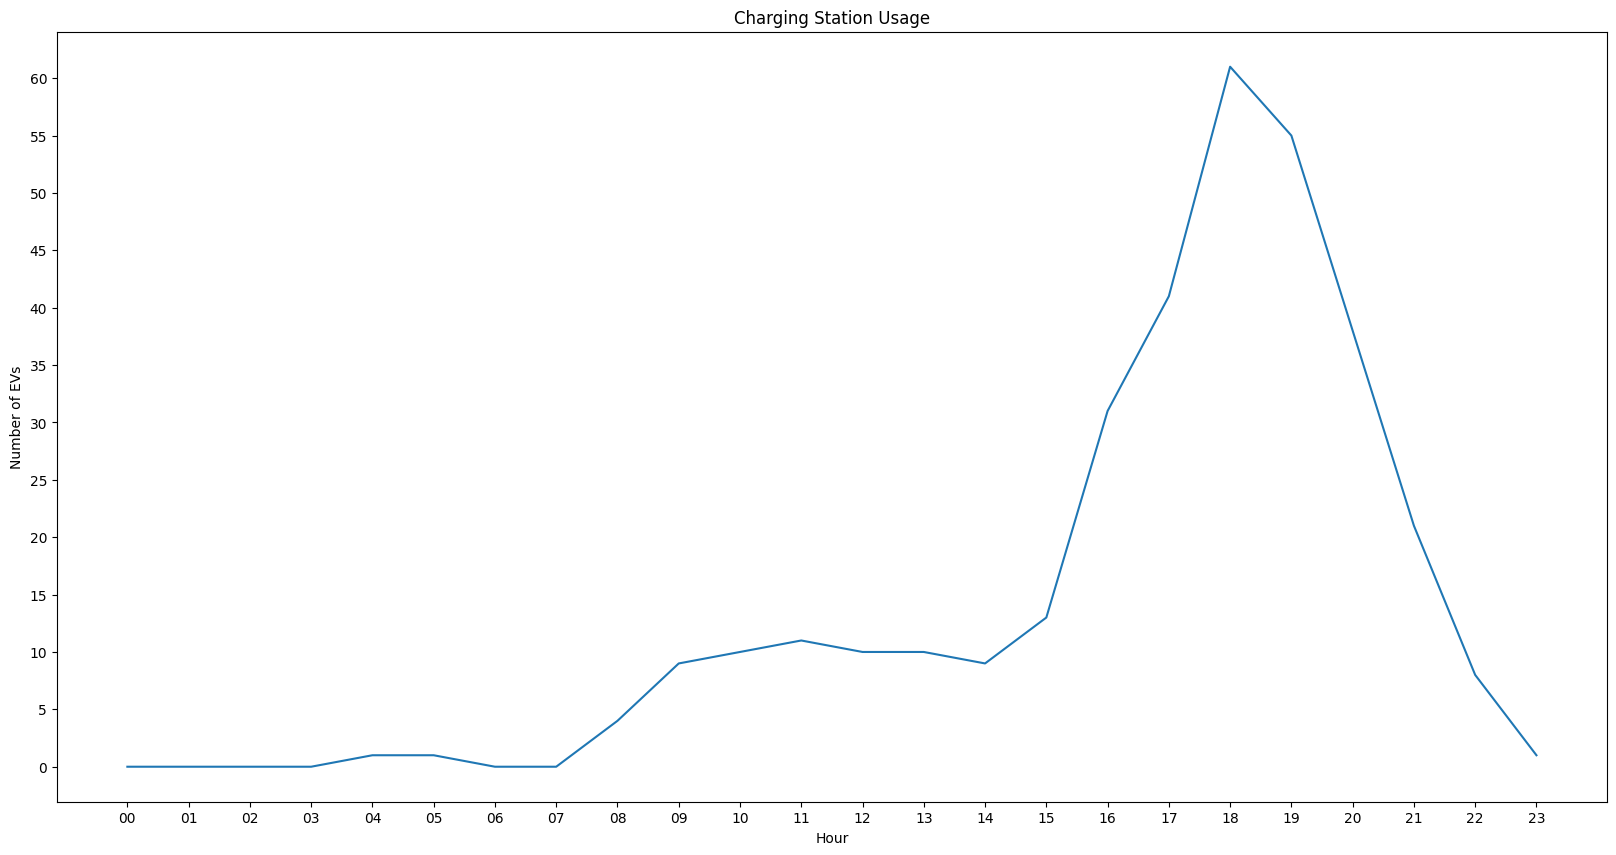

In [725]:
# Plot a timeline of the usage of the charging stations

# Create a list of colors

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Plot the data
plt.plot(np.sum(ev_charging_history_hourly, axis=0))#
# Set the title
plt.title('Charging Station Usage')

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis units
plt.yticks(np.arange(0, max(np.sum(ev_charging_history_hourly, axis=0)), 5))

# Set the y-axis label
plt.ylabel('Number of EVs')

plt.show()

In [726]:
# Create a DataFrame with the EV IDs as index and hour range as columns to indicate the charging session station power

# Create a DataFrame with the EV IDs as index
ev_charging_history_power_hourly = pd.DataFrame(index=ev_charging_history['ev_id'].unique())

# Create a list of hours
hours = list(range(0, 24))

# Create a column for each hour
for hour in hours:
    ev_charging_history_power_hourly['{:02d}'.format(hour)] = 0

# Fill the DataFrame with the charging sessions
for index, row in ev_charging_history.iterrows():
    for hour in range(row['start_hour'], row['end_hour'] + 1):
        fraction = 0
        # Check the fraction of the hour that the EV is charging
        if hour == row['start_hour']:
            fraction = 1 - (row['start_time'].minute / 60)
        elif hour == row['end_hour']:
            fraction = row['end_time'].minute / 60
        else:
            fraction = 1
        ev_charging_history_power_hourly.loc[row['ev_id'], '{:02d}'.format(hour)] += row['station_power'] * fraction

# Round the DataFrame
ev_charging_history_power_hourly = ev_charging_history_power_hourly.round(2)

# Show the DataFrame
ev_charging_history_power_hourly


,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
6ef6d268ca4df0f29fb38e8cc8a0c5e5,0,0,0,0,0.0,0.0,0,0,0.00,2.46,...,3.6,3.6,3.18,0.00,6.24,7.20,7.2,7.2,2.04,0.0
3d9dca3defb54dfc3e27263077b5f57d,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,7.2,7.2,7.20,7.20,7.20,0.12,0.0,0.0,0.00,0.0
da3a6b214f661a186e0887b52b99f2af,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0
2229e7c09b6f534bc7b5e6d227aa343b,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,3.6,3.6,3.60,3.60,3.60,0.84,0.0,0.0,0.00,0.0
1767f919a2c91b09c96d49adb56c02a2,0,0,0,0,0.0,0.0,0,0,0.36,7.20,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90390634554d4143ba06a800ee2d8920,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,0.0,0.0,2.58,0.12,0.00,0.00,0.0,0.0,0.00,0.0
83845504ac554fc9c0bc7be9cb2b73e9,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,0.0,0.0,0.00,0.00,3.84,0.36,0.0,0.0,0.00,0.0
42f1964ff88b5f09f7a45f9ac8be232a,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,0.0,0.0,0.00,0.12,1.92,0.00,0.0,0.0,0.00,0.0
88a6366302a69db06d59dfd0ed2ee42f,0,0,0,0,0.0,0.0,0,0,0.00,0.00,...,0.0,0.0,0.00,0.00,5.40,6.24,0.0,0.0,0.00,0.0


In [727]:
# Get an identical DataFrame to ev_charging_history_power_hourly but with the charging type

# Create a DataFrame with the EV IDs as index
ev_charging_history_type_hourly = pd.DataFrame(index=ev_charging_history['ev_id'].unique())

# Create a list of hours
hours = list(range(0, 24))

# Create a column for each hour
for hour in hours:
    ev_charging_history_type_hourly['{:02d}'.format(hour)] = 0

# Fill the DataFrame with the charging sessions
for index, row in ev_charging_history.iterrows():
    for hour in range(row['start_hour'], row['end_hour'] + 1):
        ev_charging_history_type_hourly.loc[row['ev_id'], '{:02d}'.format(hour)] = row['station_type']

# Show the DataFrame
ev_charging_history_type_hourly


,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
6ef6d268ca4df0f29fb38e8cc8a0c5e5,0,0,0,0,0,0,0,0,0,Fast,...,Fast,Fast,Fast,0,Slow,Slow,Slow,Slow,Slow,0
3d9dca3defb54dfc3e27263077b5f57d,0,0,0,0,0,0,0,0,0,0,...,Slow,Slow,Slow,Slow,Slow,Slow,0,0,0,0
da3a6b214f661a186e0887b52b99f2af,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2229e7c09b6f534bc7b5e6d227aa343b,0,0,0,0,0,0,0,0,0,0,...,Slow,Slow,Slow,Slow,Slow,Slow,0,0,0,0
1767f919a2c91b09c96d49adb56c02a2,0,0,0,0,0,0,0,0,Slow,Slow,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90390634554d4143ba06a800ee2d8920,0,0,0,0,0,0,0,0,0,0,...,0,0,Slow,Slow,0,0,0,0,0,0
83845504ac554fc9c0bc7be9cb2b73e9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Slow,Slow,0,0,0,0
42f1964ff88b5f09f7a45f9ac8be232a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,Slow,Slow,0,0,0,0,0
88a6366302a69db06d59dfd0ed2ee42f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Slow,Slow,0,0,0,0


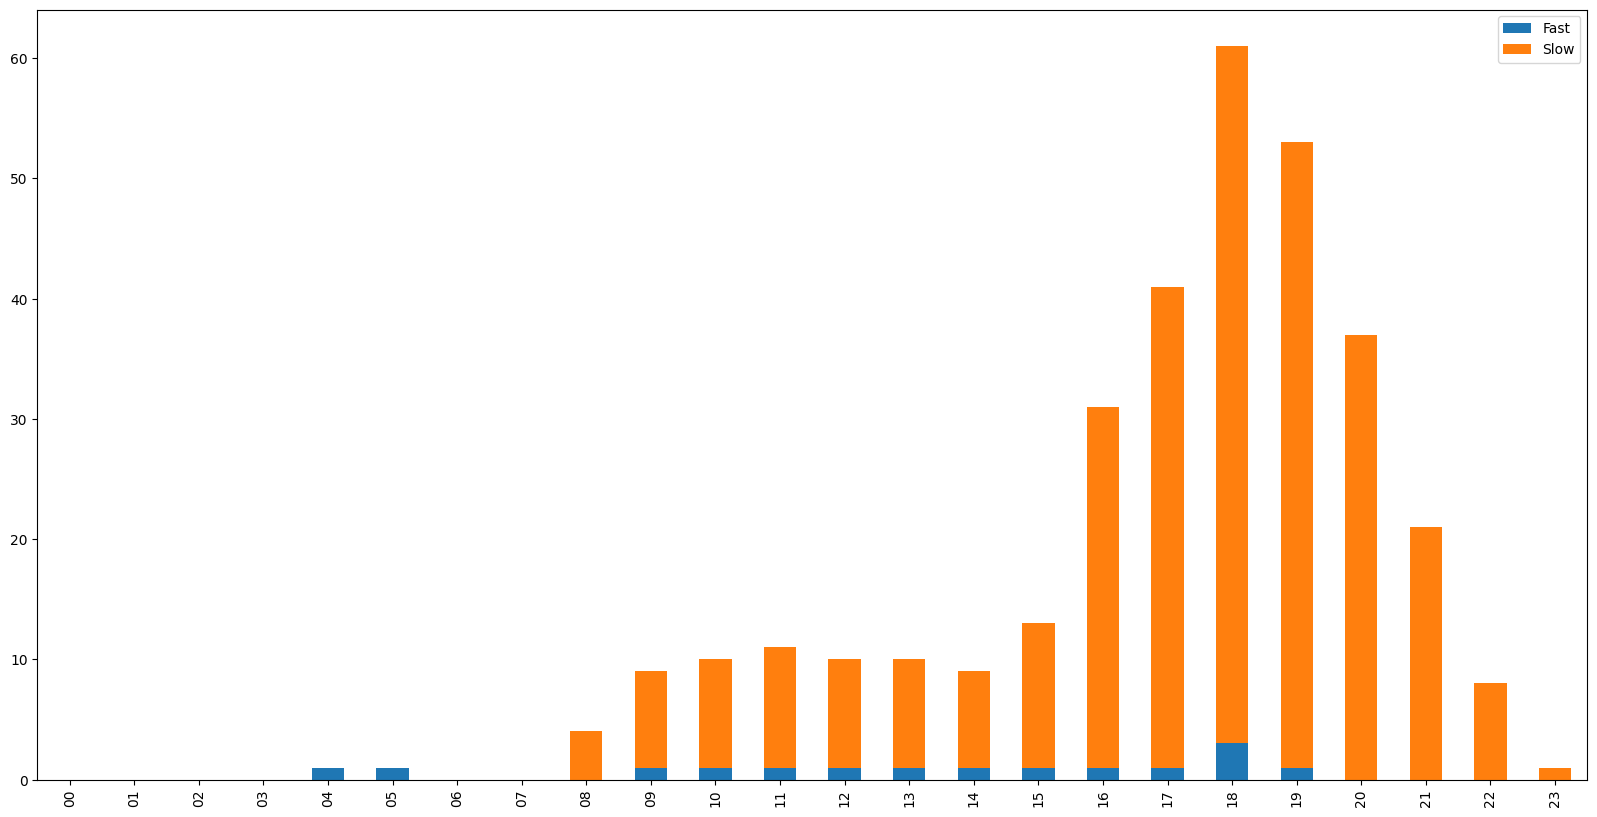

In [728]:
# Plot a stacked bar chart of the ev_charging_history_type_hourly DataFrame

# Get the value counts of each charging type at each hour
ev_charging_history_type_hourly_value_counts = ev_charging_history_type_hourly.apply(pd.value_counts, axis=0)
ev_charging_history_type_hourly_value_counts.drop(0, inplace=True)
ev_charging_history_type_hourly_value_counts = ev_charging_history_type_hourly_value_counts.fillna(0)

# Plot the data
ev_charging_history_type_hourly_value_counts.transpose().plot(kind='bar', stacked=True, figsize=(20, 10))

plt.show()

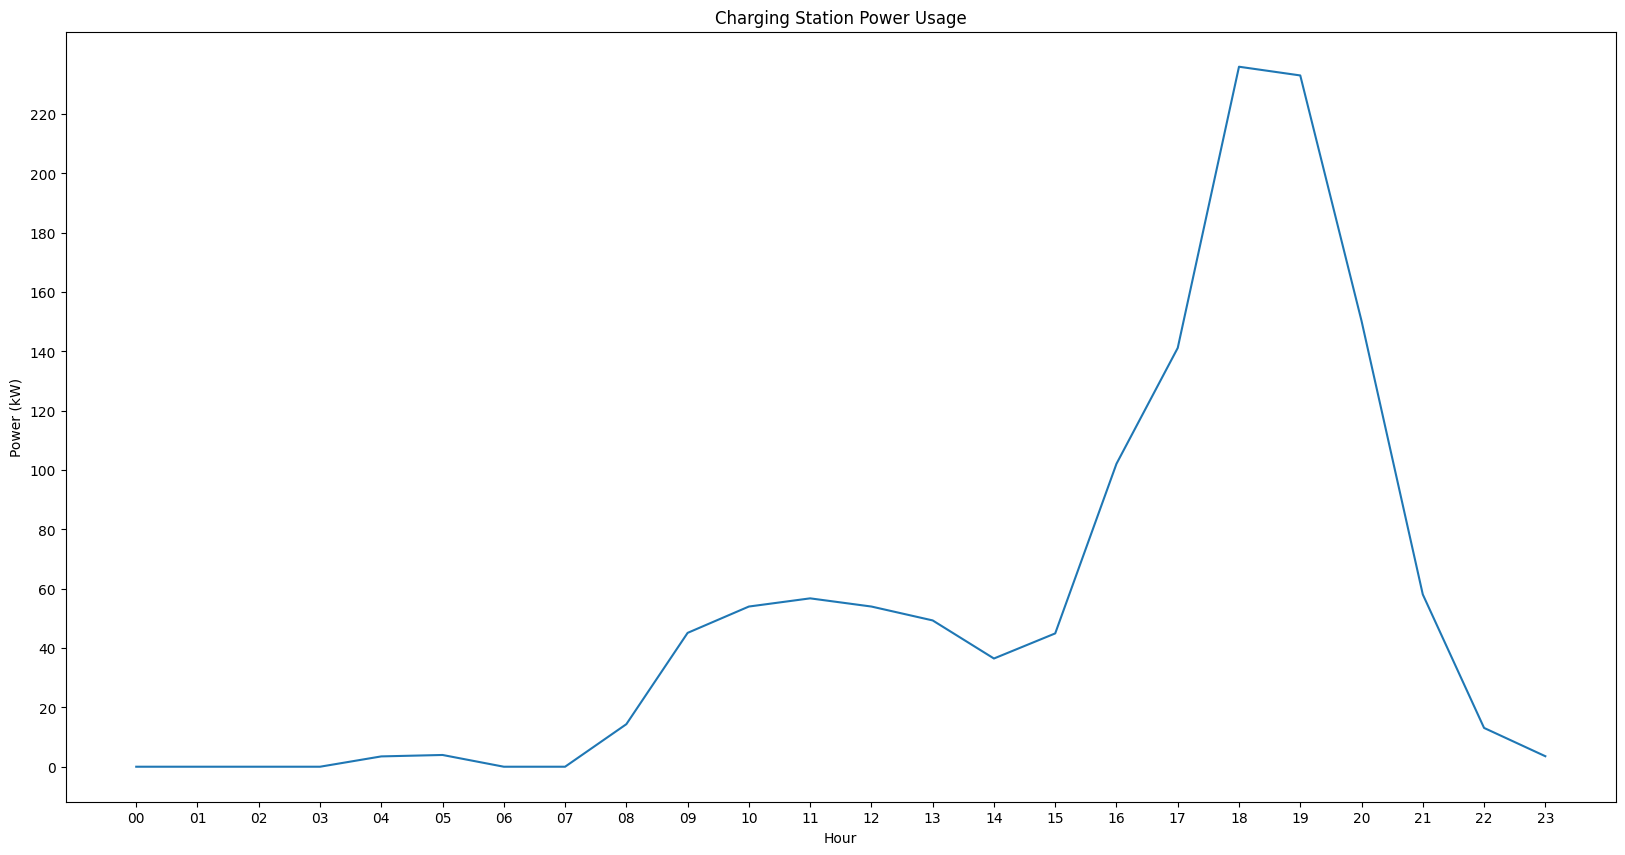

In [729]:
# Plot the sum of the power of the charging sessions at each hour

# Create a figure
fig = plt.figure(figsize=(20, 10))

plt.plot(np.sum(ev_charging_history_power_hourly, axis=0))

# Set the title
plt.title('Charging Station Power Usage')

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis units
plt.yticks(np.arange(0, max(np.sum(ev_charging_history_power_hourly, axis=0)), 20))

# Set the y-axis label
plt.ylabel('Power (kW)')

plt.show()


In [733]:
# Plot the energy required per EV by day

# Create a DataFrame with the EV IDs as index and a column for the energy required
ev_charging_history_energy = pd.DataFrame(np.sum(ev_charging_history_power_hourly, axis=1), columns=['energy'],
                                          index=ev_charging_history_type_hourly.index)

# Show the DataFrame
ev_charging_history_energy

,energy
6ef6d268ca4df0f29fb38e8cc8a0c5e5,57.12
3d9dca3defb54dfc3e27263077b5f57d,57.72
da3a6b214f661a186e0887b52b99f2af,0.00
2229e7c09b6f534bc7b5e6d227aa343b,33.24
1767f919a2c91b09c96d49adb56c02a2,31.68
...,...
90390634554d4143ba06a800ee2d8920,2.70
83845504ac554fc9c0bc7be9cb2b73e9,4.20
42f1964ff88b5f09f7a45f9ac8be232a,2.04
88a6366302a69db06d59dfd0ed2ee42f,11.64


In [752]:
# DataFrame with the EV IDs as index and a column for the energy required, profile name and trip type

# Create a DataFrame with the EV IDs as index and a column for the energy required
ev_charging_history_energy = pd.DataFrame(np.sum(ev_charging_history_power_hourly, axis=1), columns=['energy'],
                                          index=ev_charging_history_type_hourly.index)

ev_charging_history_energy['profile_name'] = 0
ev_charging_history_energy['trip_type'] = 0

# Iterate through the EVs
for ev_id in ev_charging_history_energy.index:
    # Get the assigned profiles
    temp = aggregator.assigned_segments_dataframe()

    # Get the EV profile type
    ev_profile = temp.loc[temp['ev_id'] == ev_id]['profile'].values[0]

    # Add the profile type to the DataFrame
    ev_charging_history_energy.loc[ev_id, 'profile_name'] = ev_profile.profile_name
    ev_charging_history_energy.loc[ev_id, 'trip_type'] = ev_profile.trip_type

ev_charging_history_energy

,energy,profile_name,trip_type
6ef6d268ca4df0f29fb38e8cc8a0c5e5,57.12,Work,Long
3d9dca3defb54dfc3e27263077b5f57d,57.72,Work,Long
da3a6b214f661a186e0887b52b99f2af,0.00,Work,Long
2229e7c09b6f534bc7b5e6d227aa343b,33.24,Work,Long
1767f919a2c91b09c96d49adb56c02a2,31.68,Work,Long
...,...,...,...
90390634554d4143ba06a800ee2d8920,2.70,Residential,Short
83845504ac554fc9c0bc7be9cb2b73e9,4.20,Shopping,Short
42f1964ff88b5f09f7a45f9ac8be232a,2.04,Shopping,Short
88a6366302a69db06d59dfd0ed2ee42f,11.64,Shopping,Short


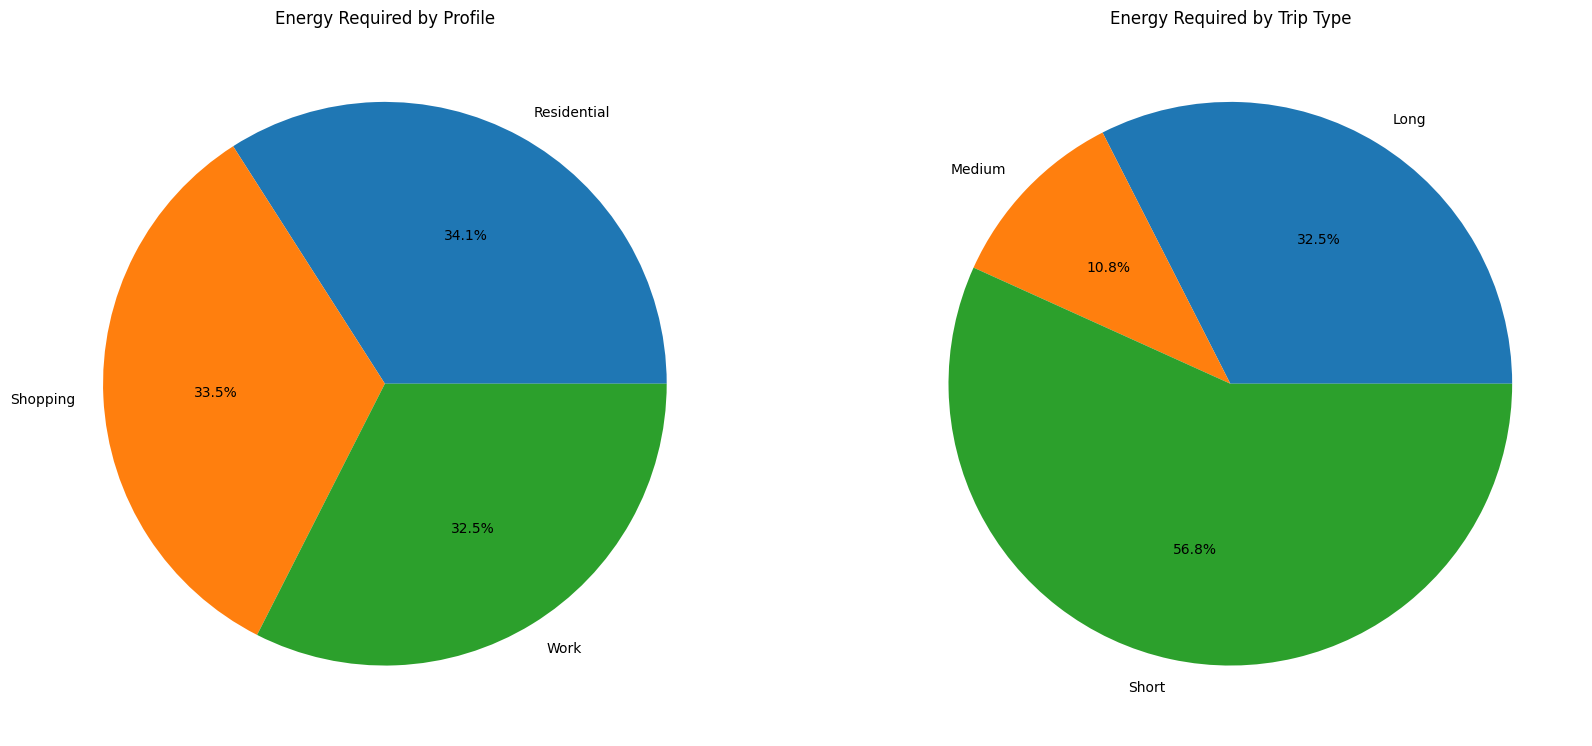

In [765]:
# Plot the energy required by the different profiles in a pie chart and the energy required by the different trip types in a pie chart

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Plot the energy required by the different profiles in a pie chart
plt.subplot(1, 2, 1)
plt.pie(ev_charging_history_energy.groupby('profile_name')['energy'].sum(), labels=ev_charging_history_energy.groupby('profile_name')['energy'].sum().index, autopct='%1.1f%%')
plt.title('Energy Required by Profile')

# Plot the energy required by the different trip types in a pie chart
plt.subplot(1, 2, 2)
plt.pie(ev_charging_history_energy.groupby('trip_type')['energy'].sum(), labels=ev_charging_history_energy.groupby('trip_type')['energy'].sum().index, autopct='%1.1f%%')
plt.title('Energy Required by Trip Type')

plt.show()
